<a href="https://colab.research.google.com/github/casecnossen/MNIST-Number-Recognition/blob/main/MNIST_num_rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries & set up device-agnostic code

In [27]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

print(torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.3.1+cu121


'cpu'

### Getting our dataset

In [28]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

In [29]:
test_data=datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

In [30]:
len(train_data), len(test_data)

(60000, 10000)

In [31]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

(-0.5, 27.5, 27.5, -0.5)

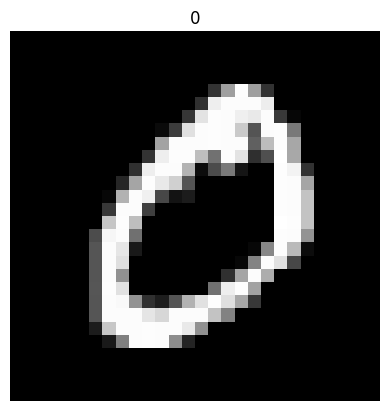

In [32]:
#Plot an example
image, label = train_data[1]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(label)
plt.axis(False)

### Prepare DataLoader

* Batching
* Shuffling
* Make data iterable

In [33]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32 #hyperparameter for batch size

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

train_features_batch, train_labels_batch = next(iter(train_dataloader))

Text(0.5, 1.0, 'tensor(1)')

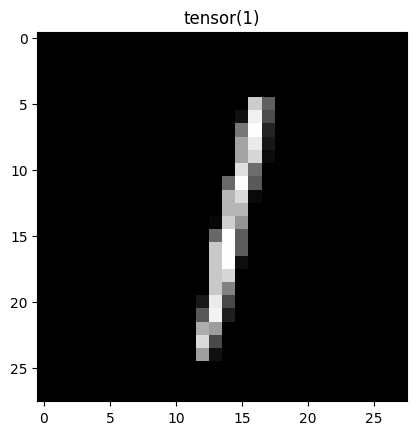

In [34]:
#Show a sample
torch.manual_seed(19)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(label)

### Build CNN Model

2 Conv blocks, 1 classifier.

Convolutional Blocks:
1. Convolutional layer (Conv2d)
2. Activation layer (ReLU)
3. Pooling layer (MaxPool2d)

In [61]:
class NumRecCNN(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
    )
  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [62]:
torch.manual_seed(13)
model = NumRecCNN(input_shape=1, hidden_units = 10, output_shape=len(class_names)).to("cpu")

### Helper Functions

* Accuracy fn

In [63]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

### Write training & testing functions.

1. Forward pass
2. Calculate loss
3. Optimizer zero grad
4. Backpropogation
5. Optimizer Step

In [64]:
def train_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, accuracy_fn, device=device):
  train_loss, train_accuracy = 0, 0
  model.train()

  train_loss=0
  for batch, (X,y) in enumerate(data_loader):
    X,y = X.to(device), y.to(device)

    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_accuracy += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= len(data_loader)
  train_accuracy /= len(data_loader)
  print(f"Train loss: {train_loss:.5f}, train accuracy: {train_accuracy:.2f}%")

def test_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn, device=device):
  test_loss, test_accuracy = 0,0
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      X,y = X.to(device), y.to(device) # device-agnostic
      test_pred=model(X)
      test_loss += loss_fn(test_pred, y)
      test_accuracy += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
    test_loss /= len(data_loader)
    test_accuracy /= len(data_loader)
    print(f"Test loss: {test_loss:.5f}, test accuracy: {test_accuracy:.2f}%")

### Pick loss function & optimizer

In [65]:
loss_fn = nn.CrossEntropyLoss() # Good for multi-class classification
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1) #Stochastic Gradient Descent

### Train & Test our model

In [67]:
torch.manual_seed(13)
torch.cuda.manual_seed(13)

epochs = 3
for epoch in range(epochs):
  print(f"Epoch: {epoch}\n----------")
  train_step(model=model,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device=device
             )
  test_step(model=model,
            data_loader = train_dataloader,
            loss_fn = loss_fn,
            accuracy_fn = accuracy_fn,
            device=device
            )

Epoch: 0
----------
Train loss: 0.07006, train accuracy: 97.84%
Test loss: 0.05321, test accuracy: 98.33%
Epoch: 1
----------
Train loss: 0.05688, train accuracy: 98.20%
Test loss: 0.06225, test accuracy: 98.00%
Epoch: 2
----------
Train loss: 0.04940, train accuracy: 98.45%
Test loss: 0.04376, test accuracy: 98.63%


### Save the model to a file directory

* `torch.save()`
* `torch.load()`
* `torch.nn.Module.load_state_dict()`

In [68]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "num_rec_cnn.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/num_rec_cnn.pth


### Trying your own images

Text(0.5, 1.0, 'Probabilities')

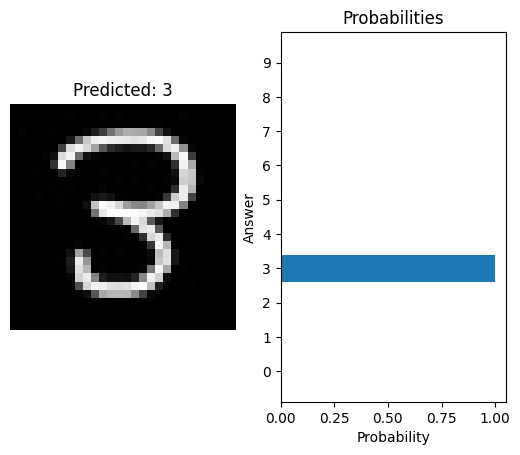

In [154]:
from PIL import Image
import numpy as np

image = Image.open("test_img.jpg")

transform = transforms.Compose([
    transforms.PILToTensor()
])

img = transform(image)

img = transforms.functional.rgb_to_grayscale(img).type(torch.float)

#Plot number & Give label as prediction
pred_label = model(img.unsqueeze(dim=0).to(device)).argmax(dim=1)

figure, axis = plt.subplots(1,2)

axis[0].imshow(img.squeeze(), cmap="gray")
axis[0].axis(False)
axis[0].set_title("Predicted: " + str(pred_label.item()))

#Plot probabilities for each number
logits=model(img.unsqueeze(dim=0).to(device))
labels = np.array(['0','1','2','3','4','5','6','7','8','9'])
probs = torch.nn.functional.softmax(logits, dim=1)

plt.barh(labels, probs.detach().numpy().squeeze())
plt.xlabel("Probability")
plt.ylabel("Answer")
axis[1].plot()
axis[1].set_title("Probabilities")